In [880]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [881]:
df = pd.read_csv('survey_results_public.csv')
df.set_index("ResponseId", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89184 entries, 1 to 89184
Data columns (total 83 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Q120                                 89184 non-null  object 
 1   MainBranch                           89184 non-null  object 
 2   Age                                  89184 non-null  object 
 3   Employment                           87898 non-null  object 
 4   RemoteWork                           73810 non-null  object 
 5   CodingActivities                     73764 non-null  object 
 6   EdLevel                              87973 non-null  object 
 7   LearnCode                            87663 non-null  object 
 8   LearnCodeOnline                      70084 non-null  object 
 9   LearnCodeCoursesCert                 37076 non-null  object 
 10  YearsCode                            87435 non-null  object 
 11  YearsCodePro                

(array([0.33, 1.58, 2.83, 4.08, 5.33, 6.58, 7.83, 9.08]),
 [Text(0.33, 0, '18-24 years old'),
  Text(1.58, 0, '25-34 years old'),
  Text(2.83, 0, '35-44 years old'),
  Text(4.08, 0, '45-54 years old'),
  Text(5.33, 0, '55-64 years old'),
  Text(6.58, 0, '65 years or older'),
  Text(7.83, 0, 'Prefer not to say'),
  Text(9.08, 0, 'Under 18 years old')])

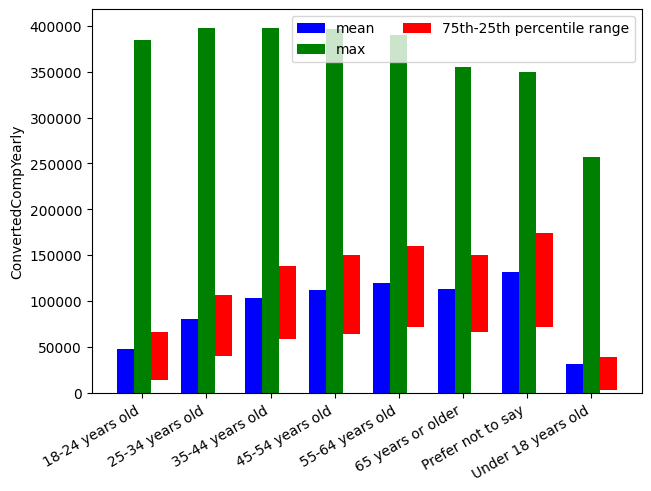

In [882]:
filtered = df[df["ConvertedCompYearly"].isna() == False]
q_hi = filtered["ConvertedCompYearly"].quantile(0.99) #get the 99th percentile (outliers, probably data errors)
filtered = filtered[filtered["ConvertedCompYearly"] < q_hi]
grouped = filtered.groupby("Age")["ConvertedCompYearly"]

indexes = grouped.mean().index
bar_width = 0.33
x = np.arange(len(grouped.mean().index))
adjusted_x = x * 1.25
fig, ax = plt.subplots(layout='constrained')

bar = ax.bar(adjusted_x, grouped.mean(), bar_width, color="blue", label="mean")
max_bar = ax.bar(adjusted_x + bar_width, grouped.max(), bar_width, color="green", label="max")

q75 = grouped.quantile(0.75)
q25 = grouped.quantile(0.25)
bar_height = q75 - q25
box_bar = ax.bar(adjusted_x + bar_width*2, bar_height, bar_width, bottom=q25, color="red", label="75th-25th percentile range")

ax.legend(ncols=2, loc="upper right")
ax.set_xticks(adjusted_x + bar_width, indexes)
ax.set_ylabel('ConvertedCompYearly')
plt.xticks(rotation=30, ha="right")

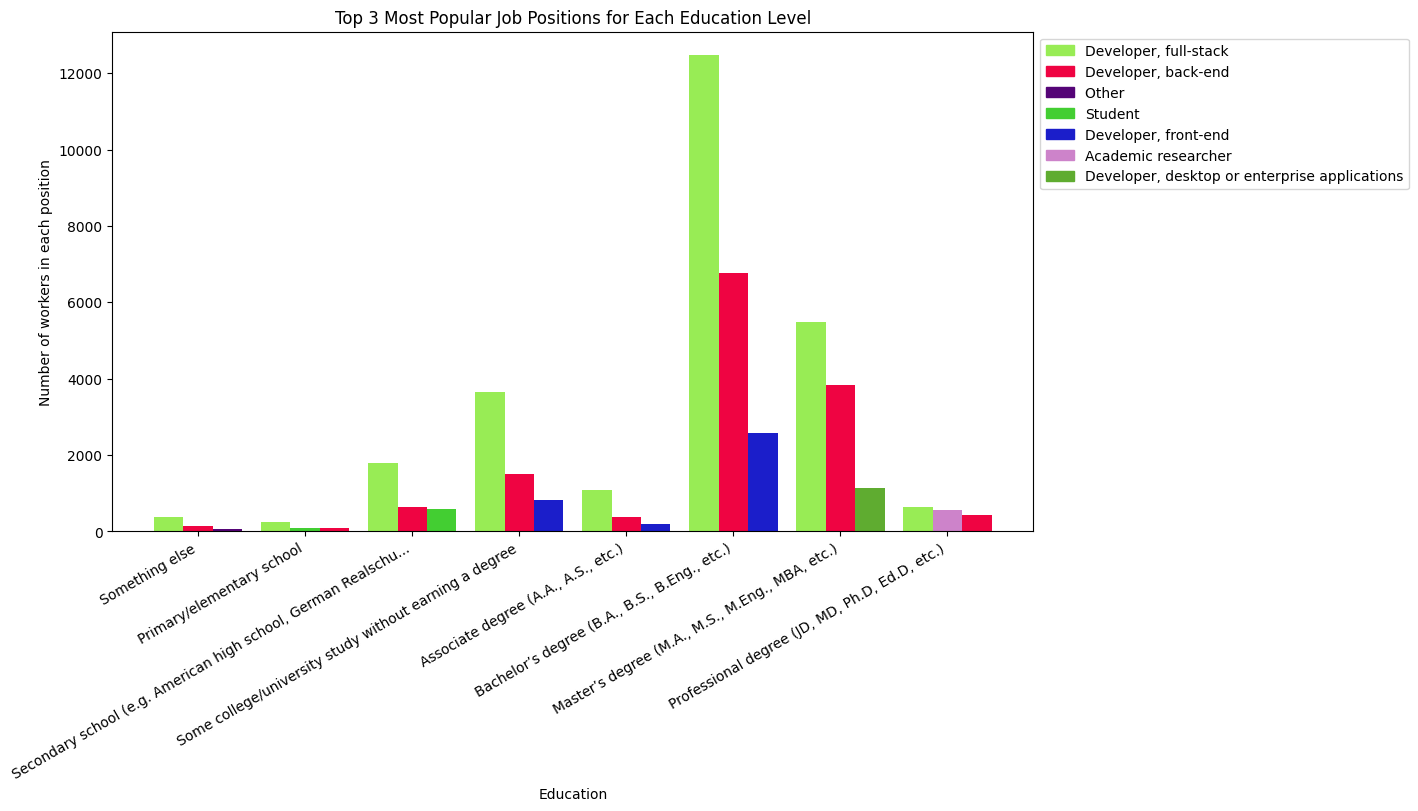

In [883]:
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import random

custom_order = [
    'Something else', 
    'Primary/elementary school', 
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 
    'Some college/university study without earning a degree',
    'Associate degree (A.A., A.S., etc.)',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)'
]
non_na_dev_types = df[df["DevType"].isna() == False]
non_na_dev_types_and_ed_levels = non_na_dev_types[non_na_dev_types['EdLevel'].isna() == False]
all_education_levels = non_na_dev_types_and_ed_levels['EdLevel'].unique()
missing_education_levels = [element for element in all_education_levels if element not in custom_order]
enhanced_custom_order = custom_order + missing_education_levels
non_na_dev_types_and_ed_levels['EdLevel'] = pd.Categorical(non_na_dev_types_and_ed_levels['EdLevel'], categories=enhanced_custom_order, ordered=True)

grouped_ed_levels = non_na_dev_types_and_ed_levels.groupby("EdLevel")

bar_width = 0.33
x = np.arange(len(grouped_ed_levels))
adjusted_x = x * 1.2

top_jobs_by_education = {}
indexes = []

for education_level, group in grouped_ed_levels:
    top_jobs = group['DevType'].value_counts().nlargest(3).index.tolist()
    top_jobs_by_education[education_level] = top_jobs
    limit = 60
    ellipsis = education_level[:limit] + ('...' if len(education_level) > limit else '')
    indexes.append(ellipsis)

fig, ax = plt.subplots(layout='constrained', figsize=(14, 8))

job_types = {
    "['Developer, full-stack']": (0.596078431372, 0.9254901960, 0.333333333, 1),
    "['Developer, back-end']": (0.9372549019, 0.01568627450, 0.2588235294, 1),
    "['Other (please specify):']":(0.333333333, 0.01568627450, 0.46666666, 1),
    "['Student']": (0.262745098, 0.8078431372, 0.19607843137, 1),
    "['Developer, front-end']": (0.1058823529, 0.117647058823, 0.79215686, 1),
    "['Academic researcher']": (0.803921568, 0.5137254901, 0.79215686274, 1),
    "['Developer, desktop or enterprise applications']": (0.3721208613689483, 0.6760034780790405, 0.18707464066071333, 1),
}

for i, (education_level, top_jobs) in enumerate(top_jobs_by_education.items()):
    education_data = grouped_ed_levels.get_group(education_level)
    job_counts = education_data['DevType'].value_counts().loc[top_jobs]
    for j in range(0,3):   
        label = str(job_counts.index[j])
        if(job_types.get(str([job_counts.index[j]]))):
            color = job_types.get(str([job_counts.index[j]]))
        else:
            color = to_rgba((random.random(), random.random(), random.random()))
            job_types[str([job_counts.index[j]])] = color
        ax.bar(adjusted_x[i] + j * bar_width, job_counts[j], bar_width, color=color, label=label)

ax.set_xlabel('Education')
ax.set_ylabel('Number of workers in each position')
ax.set_title('Top 3 Most Popular Job Positions for Each Education Level')
custom_legend = []
for key, value in job_types.items():
    custom_legend.append(Patch(color=value, label=key.replace("[\'", "").replace("\']", "").replace("(please specify):", "")))

ax.set_xticks(adjusted_x + bar_width, indexes)

plt.legend(handles=custom_legend, loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=30, ha="right")
plt.show()

(array([ 0.495,  1.995,  3.495,  4.995,  6.495,  7.995,  9.495, 10.995,
        12.495, 13.995, 15.495, 16.995, 18.495, 19.995, 21.495, 22.995,
        24.495, 25.995, 27.495, 28.995, 30.495, 31.995, 33.495, 34.995,
        36.495, 37.995, 39.495, 40.995, 42.495, 43.995, 45.495, 46.995,
        48.495]),
 [Text(0.495, 0, 'Academic researcher'),
  Text(1.995, 0, 'Blockchain'),
  Text(3.495, 0, 'Cloud infrastructure engineer'),
  Text(4.995, 0, 'Data or business analyst'),
  Text(6.495, 0, 'Data scientist or machine learning specialist'),
  Text(7.995, 0, 'Database administrator'),
  Text(9.495, 0, 'Designer'),
  Text(10.995, 0, 'DevOps specialist'),
  Text(12.495, 0, 'Developer Advocate'),
  Text(13.995, 0, 'Developer Experience'),
  Text(15.495, 0, 'Developer, QA or test'),
  Text(16.995, 0, 'Developer, back-end'),
  Text(18.495, 0, 'Developer, desktop or enterprise applications'),
  Text(19.995, 0, 'Developer, embedded applications or devices'),
  Text(21.495, 0, 'Developer, front-end

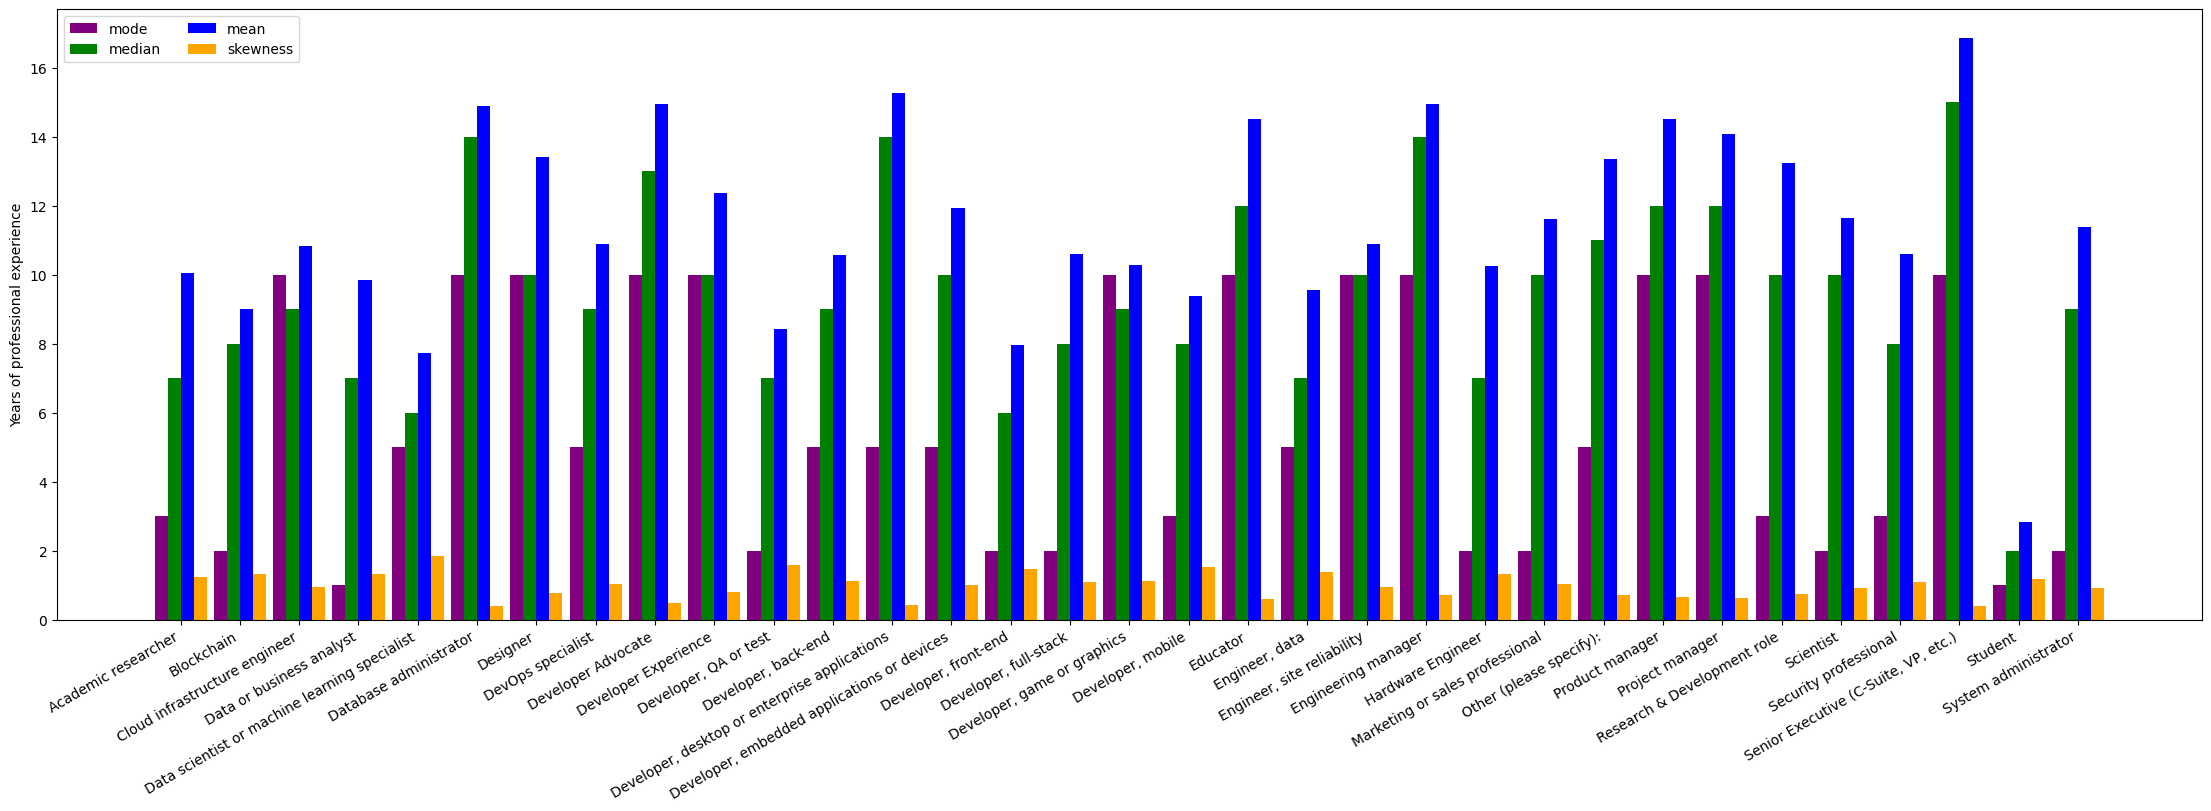

In [884]:
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
non_na_dev_types = df[df["DevType"].isna() == False]
non_na_dev_types_and_years_code = non_na_dev_types[non_na_dev_types['YearsCodePro'].isna() == False]
q_hi = non_na_dev_types_and_years_code["YearsCodePro"].quantile(0.99) #get the 99th percentile (outliers, probably data errors)
non_na_dev_types_and_years_code = non_na_dev_types_and_years_code[non_na_dev_types_and_years_code["YearsCodePro"] < q_hi]
grouped = non_na_dev_types_and_years_code.groupby("DevType")["YearsCodePro"]

indexes = grouped.mean().index
bar_width = 0.33
x = np.arange(len(grouped.mean().index))
adjusted_x = x * 1.5
fig, ax = plt.subplots(layout='constrained', figsize=(22, 8))

def custom_mode(series):
    counts = np.bincount(series)
    mode_value = np.argmax(counts)
    return mode_value

agg_functions = {
    'mean': 'mean',
    'median': 'median',
    'mode': custom_mode,
    'skewness': lambda x: x.skew(),
}

mode_values = grouped.agg(agg_functions['mode'])
median_values = grouped.agg(agg_functions['median'])
mean_values = grouped.agg(agg_functions['mean'])
skewness_values = grouped.agg(agg_functions['skewness'])

ax.bar(adjusted_x, mode_values, bar_width, color="purple", label="mode")
ax.bar(adjusted_x + bar_width, median_values, bar_width, color="green", label="median")
ax.bar(adjusted_x + bar_width * 2, mean_values, bar_width, color="blue", label="mean")
ax.bar(adjusted_x + bar_width * 3, skewness_values, bar_width, color="orange", label="skewness")

ax.legend(ncols=2, loc="upper left")
ax.set_xticks(adjusted_x + bar_width * 1.5, indexes)
ax.set_ylabel('Years of professional experience')
plt.xticks(rotation=30, ha="right")